## Restoration of the Tully-Fisher Relation with the Lucy Algorithm

*H. Fu, Dec 2023*

Total run time: ~2 min for 30 iterations.

In [1]:
""" Load catalog data """
import numpy as np
import pandas as pd
from scipy import constants 
import os

# load merged ALFALFA-SDSS catalog
alfa_df = pd.read_csv('ALFALFA_SDSS_merged.csv')
# select a subset
idx = ((alfa_df.W20 > 0) & ~(alfa_df.absMag_i.isnull()))
alfa_df = alfa_df.loc[idx, :]
print(alfa_df.shape)
# save rest-frame velocity width and i-band absolute magnitude
xdata = alfa_df['W20']/(1+alfa_df['Vhelio']/(constants.c/1e3))
ydata = alfa_df['absMag_i']

# axes labels
xlabel = 'Observed Line Width ($x$)'
xilabel = 'Edge-on Line Width ($\\xi$)'
ylabel = 'Observed Magnitude ($y$)'
etalabel = 'Face-on Magnitude ($\eta$)'

""" Key input parameters """
# the ranges of x,y,xi,eta for the joint PDF and the 2D histograms
xmin,xmax,ymin,ymax = 0,650,-23,-13

# assumed measurement errors
xsigma = 20.0
ysigma = 0.14
# i-band extinction coefficient: gamma_2 for i-band in Shao07 Table 4
gi = 0.73 
# face-on velocity width: estimated from the rectified velocity width function
w0 = 30.0 # km/s
# set number of iterations
niter = 30

# output folder
rundir = f'xsig{xsigma}_ysig{ysigma}_w{int(w0)}'
if not os.path.exists(rundir): os.mkdir(rundir)

""" Set up x,y,xi,eta grids """
# grid for projected line width in km/s
nx = 51 
xn = np.linspace(xmin,xmax,num=nx)
# spacing in x
xpix = (xmax-xmin)/(nx-1)
# grid for edge-on line width in km/s
nxi = 51
xin = np.linspace(xmin+0.1*xpix,xmax+0.1*xpix,num=nxi)

# grid for projected magnitude
ny = 51 
yn = np.linspace(ymin,ymax,num=ny)
# spacing in y
ypix = (ymax-ymin)/(ny-1)
# grid for face-on magnitude
neta = 51
etan = np.linspace(ymin,ymax,num=neta)

# number of bins for 2D histogram in each dimension
# subtract 1 so that the spacing is the same as the above grid
# albeit offset by half a pixel
nbin = nx-1 

""" Define Functions """
# PDF of projected line width
def f_x(x,xi):
    if x < xi-1e-5 and x >= w0:
        return x/xi/np.sqrt(xi**2-(x**2-w0**2))
    else:
        return 0.0

# PDF of projected magnitude
def f_y(y,eta):
    if y >= eta: 
        return np.log(10)/gi * 10.0**((eta-y)/gi)
    else:
        return 0.0
    
# Correlation between magnitude and linewidth        
def y_x(x,xi,eta):
    if x < xi-1e-5 and x >= w0:
        return eta-gi/2*np.log10(1.0-(x**2-w0**2)/xi**2)
    else:
        return 0.0

(28264, 54)


### Form 2D Histogram

- `phi_n` is transposed from `ij` indexing to the python default Cartesian `xy` indexing, where the first two dimensions (M,N) define the rows (`y`) and columns (`x`) of an image. In contrast, the Matrix `ij` indexing defines the first dimension as the columns (`x`).
- `xn` and `yn` are the edges of the bins, and `x_n` and `y_n` are the centers of the bins, that's why `nbin = nx-1`. 
- `xn` grid vs. `x_n` grid. The former is from `linspace(xmin,xmax,num=nx)` while the latter is from the grid centers of the 2D histogram `hist2d(bins=nbin,range=[[xmin, xmax], [ymin, ymax]])`. If we want `x_n` to represent the centers between each adjacent pair of `xn`, then we should specify `nbin = nx-1`; otherwise, `xn` will have a different spacing than `x_n`, because `delta xn = (xmax-xmin)/(nx-1)` while `delta x_n = (xmax-xmin)/nbin`, causing unwanted resonances.


In [2]:
import matplotlib.pyplot as plt
# form 2D histogram - output is in matrix 'ij' indexing
phi_n, xedges, yedges = np.histogram2d(xdata, ydata, bins=nbin, range=[[xmin, xmax], [ymin, ymax]], density=True)

# transpose from Matrix 'ij' indexing to Cartesian 'xy' indexing.
phi_n = np.transpose(phi_n)

# bin centers 
# note that they differ from the previously defined xn,yn arrays
# xn and yn are the edges of the bins, and x_n and y_n are the centers of the bins
x_n = np.array(xedges[:-1]+(xedges[1]-xedges[0])/2)
y_n = np.array(yedges[:-1]+(yedges[1]-yedges[0])/2)
# bin size
dx = np.mean(xedges[1:]-xedges[:-1])
dy = np.mean(yedges[1:]-yedges[:-1])

# calculate fractional error as N_err/N = 1/sqrt(N), Poisson statistics
ferr = 1.0/np.sqrt(phi_n * dx * dy * len(xdata))
# replace infinity with zero
ferr[ferr==np.inf] = 0.0
# errors of phi_n
phi_err = phi_n * ferr

/var/folders/99/8vgz00517hs0qj_5nds2hck80000gq/T/ipykernel_97943/3416874745.py:18: RuntimeWarning: divide by zero encountered in divide
  ferr = 1.0/np.sqrt(phi_n * dx * dy * len(xdata))


### Calculate 4D Convolution Kernel: $K(\xi,\eta,x,y)$

- to save processing time, use `x,y` as the last two axes of the 4D array. This has something to do with how python access memory, and the last axes are the fastest axes. 
- the joint PDF is in matrix `ij` indexing, while the distribution functions $\phi$ and $\psi$ are in the default Cartetian `xy` indexing. This will change the axis number when doing the marginalization along a desired axis.  
- runtime: a few seconds for 51x51x51x51 arrays

In [3]:
from scipy import signal # import convolve function
from scipy.interpolate import interp1d

# 2D gaussian function
def gauss2d(x,y,xsig,ysig,xctr,yctr):
    return 1./xsig/np.sqrt(2*np.pi)*np.exp(-(x-xctr)**2.0/2/(xsig**2.0)) * \
        1./ysig/np.sqrt(2*np.pi)*np.exp(-(y-yctr)**2.0/2/(ysig**2.0))

# interpolation function to find the index of y given its value
findidx = interp1d(yn,np.arange(ny),kind='quadratic',fill_value=0.0,bounds_error=False)

""" Calculate f_xy = P(x,y|xi,eta) """
# output 4D arrays - note the sequence of the parameters (this saves tons of time)
Peva = np.zeros((nxi,neta,nx,ny)) # before error convolution
# get grid size
dx = xn[1]-xn[0]
dy = yn[1]-yn[0]
# evalulate f_xy(x,y) for each (xi,eta)
for i in range(nxi):
    for j in range(neta): 
        xi = xin[i]
        eta = etan[j]
        # calculate f_x = PDF(x)
        Pfun = np.array([f_x(x,xi) for x in xn])
        # find the corresponding y value for each xn 
        ynval = np.array([y_x(x,xi,eta) for x in xn])
        # find indices for ynval
        yidx0 = (findidx(ynval)).astype(int)
        # compute the gradient (ny-1 array)
        dyn = np.abs(ynval[1:]-ynval[:-1])
        nypix = (np.clip(np.ceil(dyn/dy),1,None)).astype(int)
        # distribute Pfun[k] over nypix[k] - ensure continuity (no gaps)
        Ptmp = np.zeros((nx,ny))
        for k in range(nx):
            if Pfun[k] > 0:
                yidx1 = np.clip(yidx0[k]-nypix[k-1],None,ny-1)
                Ptmp[k,yidx1+1:yidx0[k]+1] = Pfun[k]/nypix[k-1]
        # normalize
        Pint = np.trapz(np.trapz(Ptmp, xn, axis=0), yn, axis=0)
        # save to 4D array
        if Pint > 0: Peva[i,j,:,:] = Ptmp/Pint

""" calculate kernel K(x,y|xi,eta) """
# output 4D arrays - note the sequence of the parameters
Keva = np.zeros((nxi,neta,nx,ny)) # after error convolution
# 2D gaussian function for error convolution
X,Y = np.meshgrid(xn,yn,indexing='ij')
x0,y0 = xn.mean(),yn.mean()
errpsf = gauss2d(X,Y,xsigma,ysigma,x0,y0)
for i in range(nxi):
    for j in range(neta): 
        Ptmp = Peva[i,j,:,:]
        # convolve with 2D Gaussian
        Ktmp = signal.convolve(Ptmp,errpsf,mode='same',method='fft')
        # normalize
        Kint = np.trapz(np.trapz(Ktmp[:,:], xn, axis=0), yn, axis=0)
        # save to 4D array after trimming out the mirrored part
        if Kint > 0: Keva[i,j,:,:] = Ktmp/Kint

Calculating Peva ...
Calculating Keva ...


In [4]:
""" Interpolate the kernel K(x,y|xi,eta) """
from scipy.interpolate import RegularGridInterpolator

# define Kernel function K(x,y|xi,eta) with interpolation
Kfun = RegularGridInterpolator((xin,etan,xn,yn),Keva,method='linear',fill_value=0.0,bounds_error=False)

## Start iterative procedure using the histogram

1. Start from an initial guess of the $\psi^0(\xi,\eta)$ function on a regular grid of $\xi_n, \eta_n$ (named as `xi_n`, `eta_n`). In this version, we make the initial guess of $\psi^0(\xi,\eta)$ the same as $\tilde{\phi}(\tilde{x},\tilde{y})$ and make the $\xi_n, \eta_n$ grid the same as the $x_n, y_n$ grid used to form the histogram.

2. For each $\xi$ value on the $\xi_n$ grid defined in Step 1, update $\psi^{r+1}$ based on the integral:
    - First calculate $\phi^r(\tilde{x},\tilde{y}) = f(\tilde{y}) \int \int \psi^r(\xi,\eta) K(\tilde{x},\tilde{y}|\xi,\eta)d\xi d\eta$
    - Then calculate $\psi^{r+1}(\xi,\eta) = \psi^r(\xi,\eta) \int \int \frac{\tilde{\phi}(\tilde{x},\tilde{y})}{\phi^r(\tilde{x},\tilde{y})} K(\tilde{x},\tilde{y}|\xi,\eta) d\tilde{x}d\tilde{y}$
    - use the `x_n, y_n` grid from data histogram for the integral over $dx,dy$
    - use the `xi_n, eta_n` grid for initial guess of $\psi^0(\xi,\eta)$ for the integral over $d\xi, d\eta$.

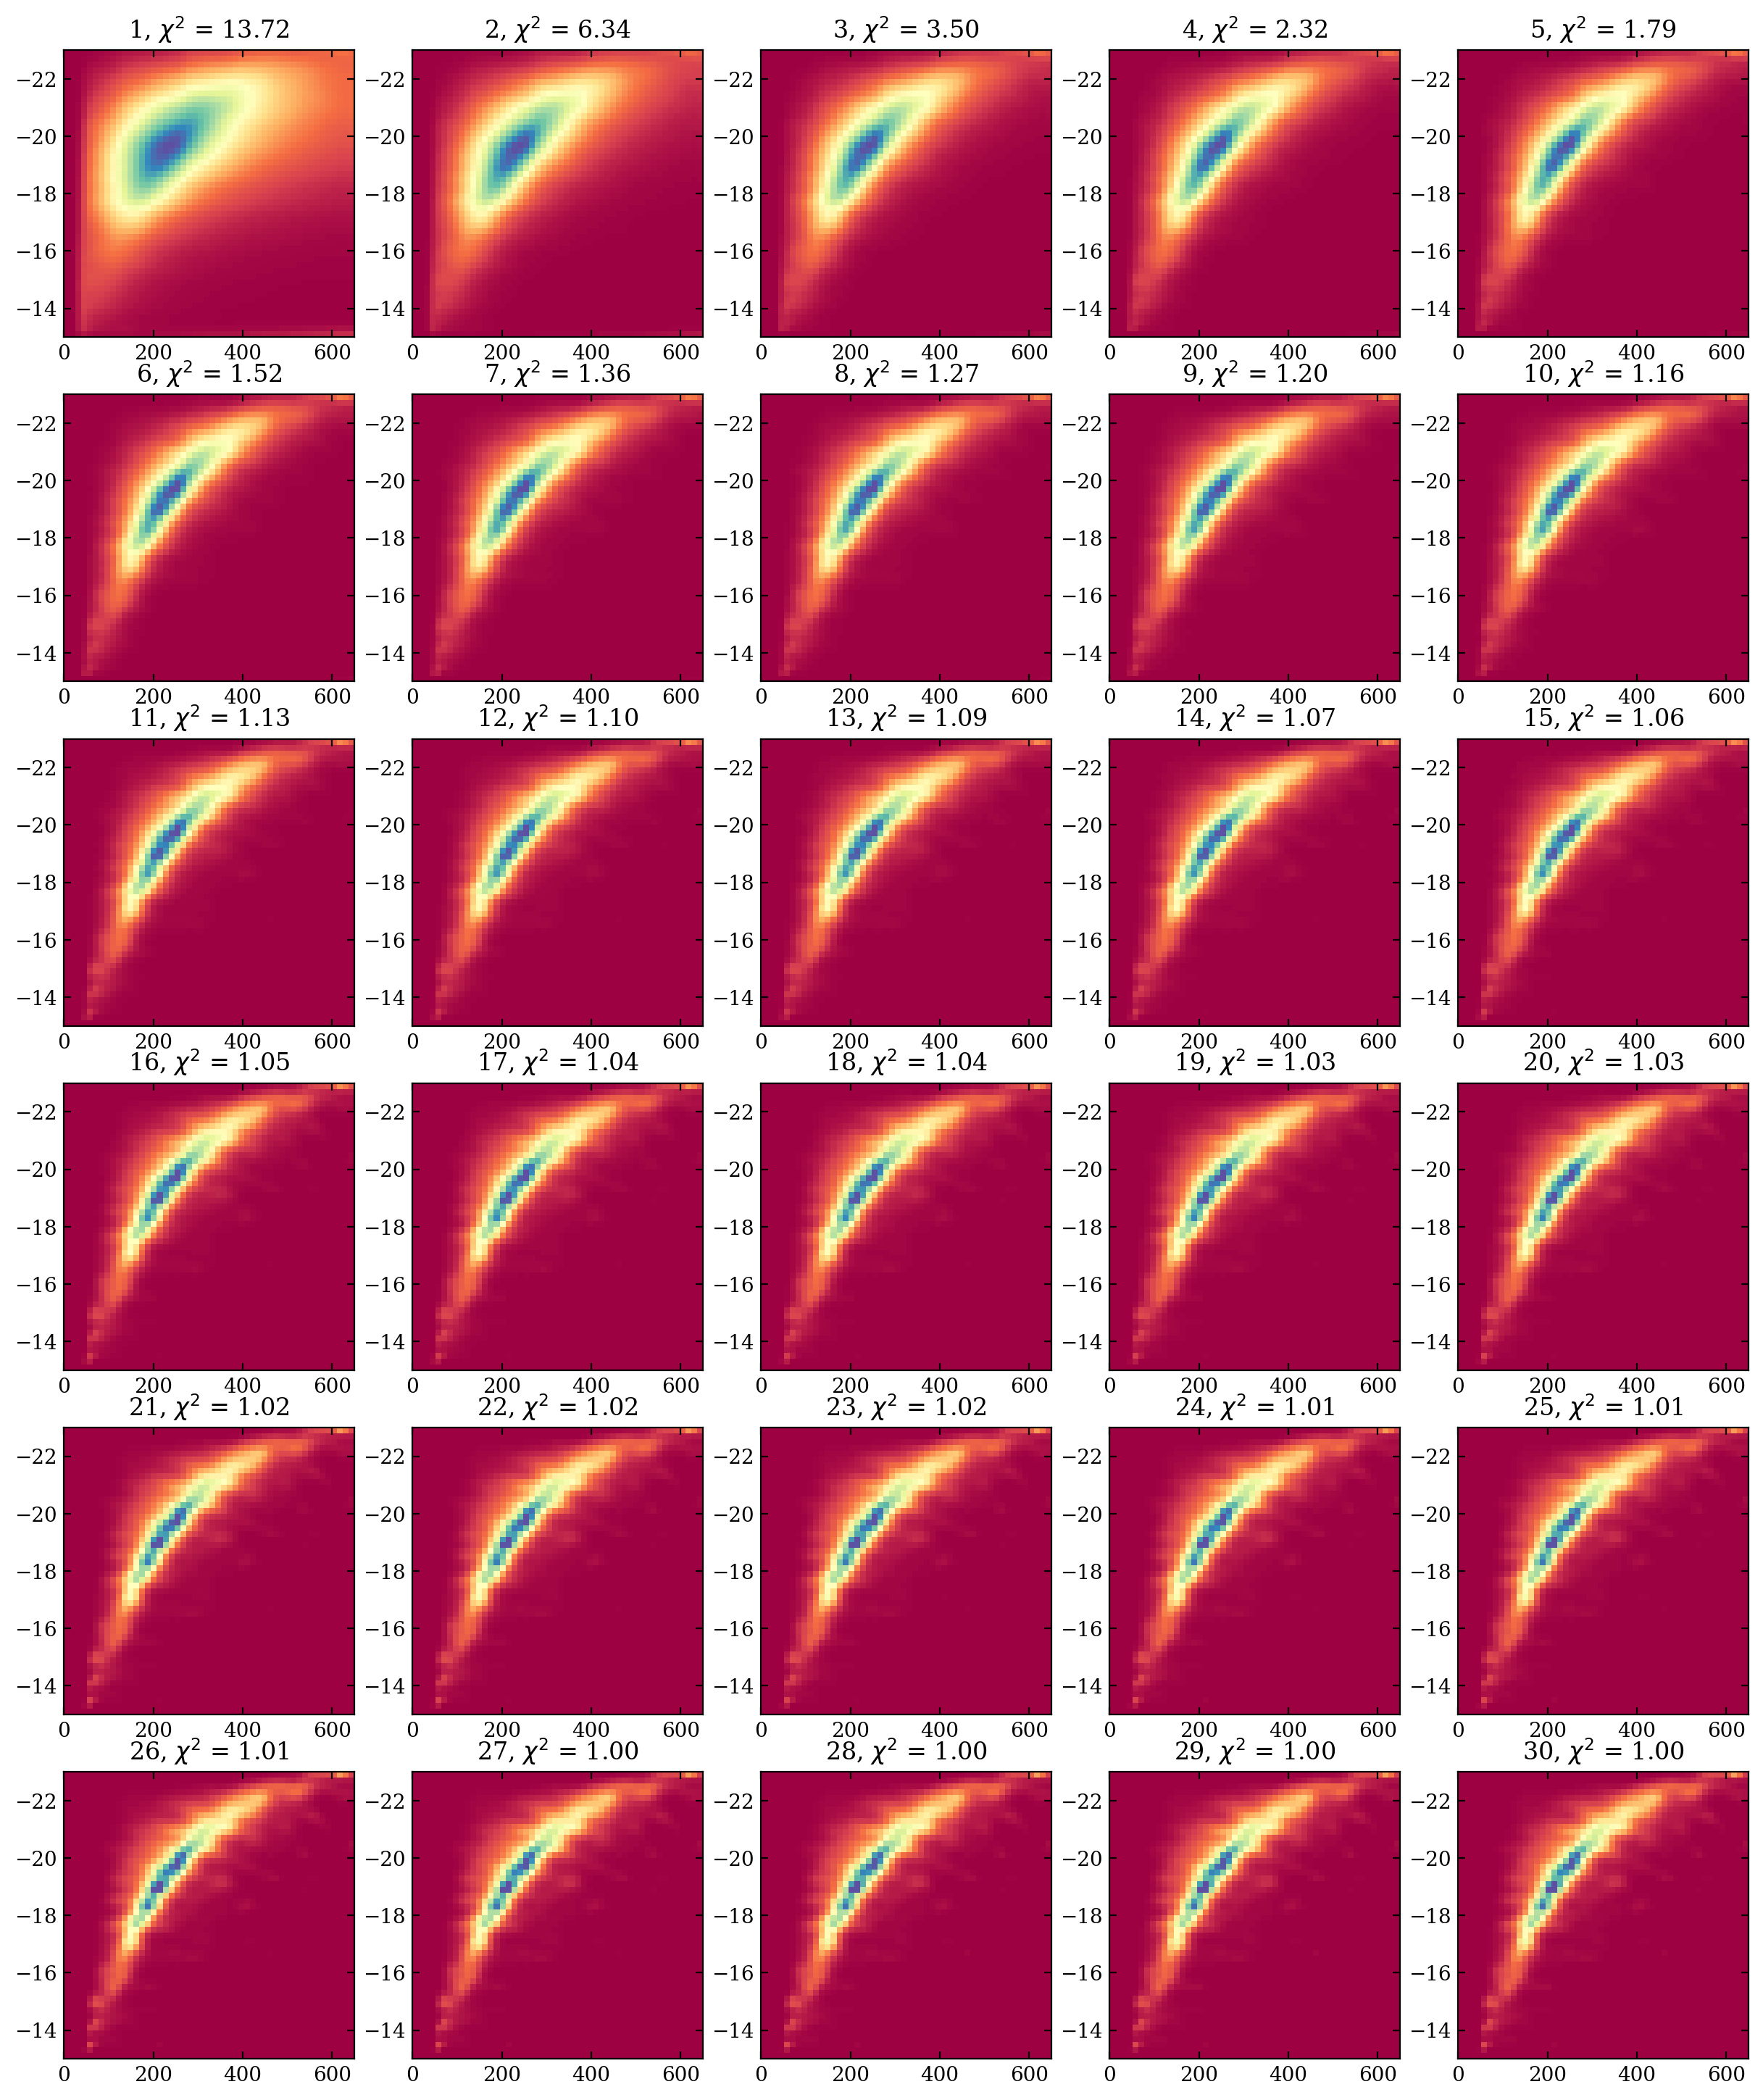

In [5]:
# make xi_n, eta_n array identical to x_n, y_n array
xi_n = np.copy(x_n)
eta_n = np.copy(y_n)

# get array lengths
nx   = len(x_n)
ny   = len(y_n)
nxi  = len(xi_n)
neta = len(eta_n)

# initialize \Psi^r(\xi,\eta) for the first iteration
# make it a flat distribution within the parameter ranges
psi_r = np.zeros((ny,nx))+1.0
psi_r *= np.sum(phi_n)/np.sum(psi_r) # normalize

# initialize \phi^r(x,y) as all zeros
phi_r = np.zeros((ny,nx))

# set up plotting grid to show evolution of psi or phi in each iteration
if niter < 51:
    ncols = 5
    nrows = int(niter/ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols,3*nrows))
    XI,ETA = np.meshgrid(xi_n,eta_n,indexing='xy')
    X,Y = np.meshgrid(x_n,y_n,indexing='xy')

# indices to calculate chi^2: 1382 1001 754 out of 2500 bins, respectively.
ind1 = (ferr > 0) & (ferr < 1./np.sqrt(4)) # all bins w/ more than 4 galaxies
# initialize chi^2 array
chisq1 = []

# start iteration
iter = 0
while iter < niter:
    # first, calculate phi^r(x_n,y_n), which is independent of xi and eta
    for i in range(len(x_n)):
        for j in range(len(y_n)):
            A,B,C,D = np.meshgrid(xi_n,eta_n,x_n[i],y_n[j],indexing='ij')
            Kernel = Kfun((A,B,C,D))
            # transpose Kernel from ij -> xy indexing 
            f_n = psi_r * np.transpose(Kernel[:,:,0,0])
            phi_r[j,i] = np.trapz(np.trapz(f_n, eta_n, axis=0), xi_n, axis=0)
    # save reduced chi^2 value for each iteration
    chisq1.append(np.mean((phi_n[ind1]-phi_r[ind1])**2/(phi_err[ind1]**2)))

    # then, calculate psi^r+1(xi_n, eta_n)
    for i in range(nxi):
        for j in range(neta):
            A,B,C,D = np.meshgrid(xi_n[i],eta_n[j],x_n,y_n,indexing='ij')
            Kernel = Kfun((A,B,C,D))
            # transpose Kernel from ij -> xy indexing 
            # add 1e-12 to avoid 0 divisions
            g_n = phi_n/(phi_r+1e-12) * np.transpose(Kernel[0,0,:,:])
            # update psi(xi) at iteration r+1
            psi_r[j,i] *= np.trapz(np.trapz(g_n, y_n, axis=0), x_n, axis=0)
    # increment iter
    iter += 1

    # make a plot after each iteration
    if niter < 51:
        k,l = int((iter-1)/ncols),(iter-1) % ncols
        # plot psi^r(xi_n,eta_n)
        ax[k,l].pcolormesh(XI, ETA, psi_r, cmap='Spectral') # , vmin=vmin, vmax=vmax) 
        ax[k,l].set_title(f'{iter}, $\chi^2$ = {chisq1[-1]:.2f}')
        ax[k,l].set_ylim(ymax,ymin)

    # save results to a .npz file every 10 iterations
    if (iter % 10 == 0):
        np.savez(rundir+f'/phi_psi_n{iter}',
                niter=iter,
                x_n=x_n,y_n=y_n,xi_n=xi_n,eta_n=eta_n,
                phi_n=phi_n,phi_r=phi_r,psi_r=psi_r,chisq1=chisq1,
                xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,
                xlabel=xlabel,ylabel=ylabel,xilabel=xilabel,etalabel=etalabel)
        
if niter < 51:
    # save plot as png file
    plt.savefig(rundir+f'/resid_n{niter}.png', bbox_inches='tight');